In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.layouts import row

%matplotlib inline


# PCAs - general data exploration
* PUDs and TUDs
* Area inundation from SLR 

### PUD and TUD distributions for the PCA network

PCA shapefile for PUDs and TUDs is the one provided here: https://abag.ca.gov/priority/conservation/, 

dissolved versions dissolved on 'joinkey', which appeared to be a unique identifier.

non-dissolved versions don't dissolve, and use the concat of ('joinkey', 'fipco') as the unique id, which matches what bcdc did during their slr intersections...

In [2]:
# pudtable = pd.read_csv('../flickr/userdays_avg_annual_bypid.csv')
pudtable = pd.read_csv('../flickr/not_dissolved/userdays_avg_annual_bypid.csv')
pudtable.rename(columns={'avg_ann_ud':'pud'}, inplace=True)

In [3]:
# tudtable = pd.read_csv('../twitter/userdays_avg_annual_bypid.csv')
tudtable = pd.read_csv('../twitter/tud_nondissolved_pcas/userdays_avg_annual_bypid.csv')
tudtable.rename(columns={'avg_ann_ud':'tud'}, inplace=True)

In [4]:
data = pudtable.merge(tudtable, on='pid')

In [5]:
data.shape

(186, 3)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f463a15b6a0>], dtype=object)

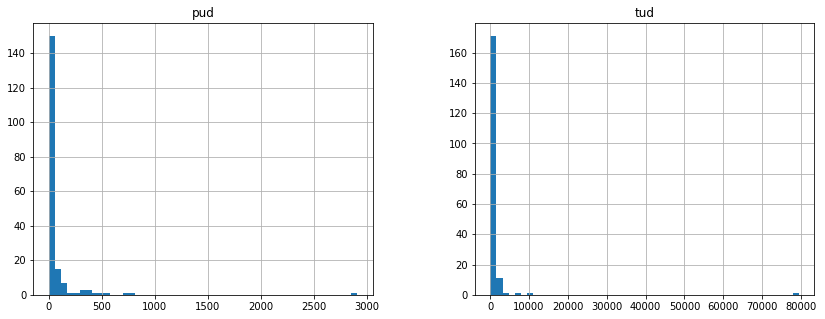

In [6]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.hist('pud', bins=50, ax=axs[0])
data.hist('tud', bins=50, ax=axs[1])

In [7]:
data['logpud'] = np.log1p(data['pud'])
data['logtud'] = np.log1p(data['tud'])

### PUD and TUD are correlated, but capture slightly different visitation patterns

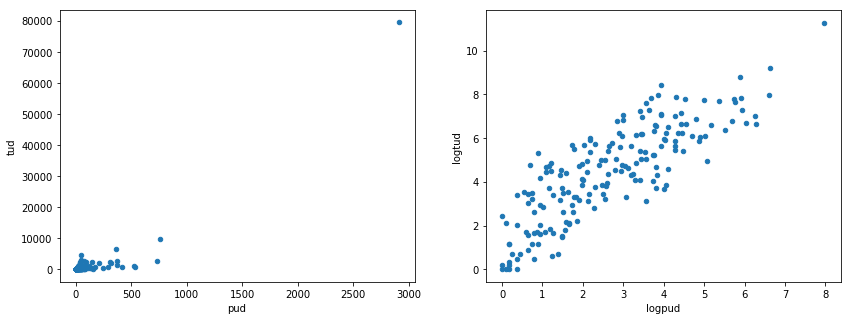

In [8]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.plot.scatter(x='pud', y='tud', ax=axs[0])
data.plot.scatter(x='logpud', y='logtud', ax=axs[1])

### PUD, TUD are influenced by area of PCA

In [9]:
# pca_shp = gpd.read_file('../twitter/shp/Priority_Conservation_Areas_current_dissolve_pid.shp')
pca_shp = gpd.read_file('../twitter/tud_nondissolved_pcas/shp/Priority_Conservation_Areas_current_pid.shp')

In [11]:
pca_shp['area_m2'] = pca_shp.area
data = data.merge(pca_shp[['area_m2', 'pid', 'name', 'joinkey', 'fipco']], on='pid')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4639dfd7f0>]], dtype=object)

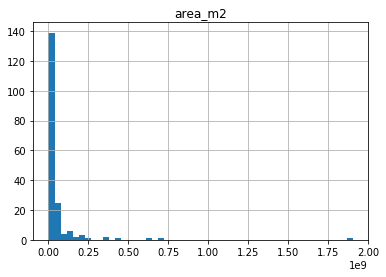

In [12]:
data.hist('area_m2', bins=50)

In [13]:
data['logarea'] = np.log1p(data['area_m2'])

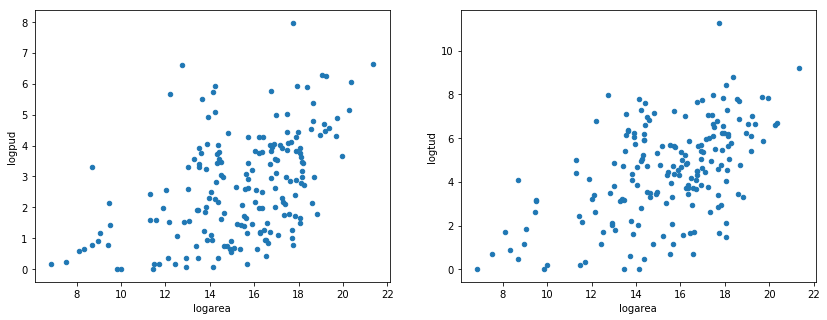

In [14]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.plot.scatter(x='logarea', y='logpud', ax=axs[0])
data.plot.scatter(x='logarea', y='logtud', ax=axs[1])

In [15]:
data['pud_per_m2'] = data['pud']/data['area_m2']
data['tud_per_m2'] = data['tud']/data['area_m2']

#### break visitation density measures into deciles, so we can easily glance at the top 10% of PCAs, for example

In [16]:
# data['pudden_tile'] = pd.qcut(data['pud_per_m2'], q=10, labels=False)
# data['tudden_tile'] = pd.qcut(data['tud_per_m2'], q=10, labels=False)

### Add Designation type of each PCA to the table

#### load some PCA metadata - the 'designation' of each PCA as:
NL = Natural Landscape  
AL = Agricultural Land  
UG = Urban Greening  
RR = Regional Recreation

In [17]:
designation = pd.read_csv('../pca/FINAL_List_of_165_PCAs_Designations.csv')
# Source: https://abag.ca.gov/priority/conservation/pdfs/FINAL_List_of_165_PCAs_Approved_as_of_September_2015.pdf

In [18]:
designation['NL'] = designation['Designation'].str.extract('(NL)')
designation['AL'] = designation['Designation'].str.extract('(AL)')
designation['UG'] = designation['Designation'].str.extract('(UG)')
designation['RR'] = designation['Designation'].str.extract('(RR)')

/home/dmf/miniconda3/envs/geowork/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':
/home/dmf/miniconda3/envs/geowork/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app
/home/dmf/miniconda3/envs/geowork/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  app.launch_new_instance()
/home/dmf/miniconda3/envs/geowork/lib/python3.6/site-packages/ipykernel/__main__.py

In [20]:
data = pd.merge(data, designation, left_on='joinkey', right_on='Area ID', how='left')

In [21]:
data.to_csv('../pca/pca_vis_designation.csv', index=False)

## PCA x SLR scenarios

In [145]:
import glob
import numpy as np
from functools import reduce
from bokeh.charts import TimeSeries, show, output_file

In [38]:
glob.glob(os.path.join(basedir, scen, '*_pid'))

['../bcdc_slr/PCAexposure_201710/slr_scenarios/100yr/diss3_pid']

In [139]:
def join_scenario_puds(scenario, whole_pca_df):
    print(scenario)
    # table with userdays in the scenario polygons, keyed by pid
    spud = pd.read_csv(os.path.join(scenario, "userdays_avg_annual_bypid_2005_2015.csv"))
#     print(np.all(np.isnan(spud['avg_ann_ud'])))
    
    # table linking userdays id (pid) and scenario polygon id (FID_spjoin)
    # sometimes this table includes an 'area' column sometimes not, we won't use it
    pid_fidspjoin_crswlk = pd.read_csv(glob.glob(os.path.join(scenario, '*_pid'))[0])
    pid_fidspjoin_crswlk = pid_fidspjoin_crswlk[['FID_spjoin', 'pid']]
    
    # table linking scenario polygon id (TARGET_FID) and master PCA unique id (joinkey, fipco)
    fidspjoin_joinkey_crswlk = gpd.read_file(glob.glob(os.path.join(scenario, 'spjoin*.dbf'))[0])
    fidspjoin_joinkey_crswlk = fidspjoin_joinkey_crswlk[['TARGET_FID', 'joinkey', 'fipco', 'name']]
    
    # joins to get scenario userdays linked to master PCA unique id (joinkey, fipco)
    spud_fid = pd.merge(spud, pid_fidspjoin_crswlk, on='pid')
    np.all(np.isnan(spud_fid['avg_ann_ud']))
    dat = pd.merge(spud_fid, fidspjoin_joinkey_crswlk, left_on='FID_spjoin', right_on='TARGET_FID')
#     print(np.all(np.isnan(dat['avg_ann_ud'])))
    
    ## join scenario PUDs to whole PUDs
    dat2 = pd.merge(dat, whole_pca_df, on=['joinkey', 'fipco'], how='right')
#     print(np.all(np.isnan(dat2['avg_ann_ud'])))
    
    # proportion of PUD that are inside the flood zone
    scen = os.path.basename(scenario)
    dat2[scen] = dat2['avg_ann_ud']/dat2['pud']
#     print(list(dat2))
    return(dat2[['joinkey', 'fipco', scen]])

In [98]:
data = pd.read_csv('../pca/pca_vis_designation.csv', dtype={'fipco': 'str'})

In [117]:
basedir = '../bcdc_slr/PCAexposure_201710/slr_scenarios/'
# for now excluding the FEMA scenarios since they have different unique ID column name in diss.shp
scenarios = ['12inches', '24inches', '36inches',  '48inches', '52inches', '66inches', '77inches', '84inches', '96inches', '108inches']

In [140]:
results = []
for scen in scenarios:
    results.append(join_scenario_puds(os.path.join(basedir, scen), data))

../bcdc_slr/PCAexposure_201710/slr_scenarios/12inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/24inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/36inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/48inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/52inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/66inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/77inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/84inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/96inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/108inches


In [164]:
slrdata = reduce(lambda x, y: pd.merge(x, y, on = ['joinkey', 'fipco']), results)
# slrdata = pd.concat(results, axis=1, keys=scenarios)

In [165]:
slrdata.head()

,joinkey,fipco,12inches,24inches,36inches,48inches,52inches,66inches,77inches,84inches,96inches,108inches
0,MR4,6041,0.006978,0.011165,0.011863,0.137474,0.139567,0.152128,0.161898,0.166783,0.167481,0.167481
1,MR15,6041,0.618304,0.642857,0.658482,0.946429,0.962054,0.984375,0.991071,0.993304,0.995536,0.995536
2,MR18,6041,0.546512,0.651163,0.709302,0.831395,0.837209,0.889535,0.889535,0.889535,0.901163,0.912791
3,MR14,6041,0.000000,0.000000,0.000000,0.309278,0.319588,0.407216,0.412371,0.412371,0.412371,0.412371
4,MR9,6041,0.274892,0.538961,0.774892,0.900433,0.924242,0.941558,0.950216,0.956710,0.956710,0.958874


In [166]:
slrdata['uid'] = slrdata['joinkey']+slrdata['fipco']
slrdata.drop(labels=['joinkey', 'fipco'], axis='columns', inplace=True)

In [167]:
slrdata.set_index('uid', inplace=True)

In [168]:
slrdata.head()

,12inches,24inches,36inches,48inches,52inches,66inches,77inches,84inches,96inches,108inches
uid,,,,,,,,,,
MR46041,0.006978,0.011165,0.011863,0.137474,0.139567,0.152128,0.161898,0.166783,0.167481,0.167481
MR156041,0.618304,0.642857,0.658482,0.946429,0.962054,0.984375,0.991071,0.993304,0.995536,0.995536
MR186041,0.546512,0.651163,0.709302,0.831395,0.837209,0.889535,0.889535,0.889535,0.901163,0.912791
MR146041,0.000000,0.000000,0.000000,0.309278,0.319588,0.407216,0.412371,0.412371,0.412371,0.412371
MR96041,0.274892,0.538961,0.774892,0.900433,0.924242,0.941558,0.950216,0.956710,0.956710,0.958874


In [169]:
tslrdata = pd.DataFrame.transpose(slrdata)

In [170]:
tslrdata.head()

uid,MR46041,MR156041,MR186041,MR146041,MR96041,MR116041,MR86041,AL116001,AL266001,AL186001,...,CC246013,CC226013,MULTI66013,NP86055,NP96055,NP46055,NP36055,NP26055,NP106055,NP56055
12inches,0.006978,0.618304,0.546512,0.000000,0.274892,0.000000,0.161972,0.014493,0.072860,0.010526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24inches,0.011165,0.642857,0.651163,0.000000,0.538961,0.087719,0.169014,0.014493,0.098361,0.010526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36inches,0.011863,0.658482,0.709302,0.000000,0.774892,0.087719,0.183099,0.014493,0.153005,0.010526,...,NaN,0.057143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48inches,0.137474,0.946429,0.831395,0.309278,0.900433,0.087719,0.190141,0.014493,0.285974,0.010526,...,NaN,0.114286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52inches,0.139567,0.962054,0.837209,0.319588,0.924242,0.087719,0.204225,0.014493,0.422587,0.010526,...,NaN,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
# longdf = pd.melt(slrdata, id_vars=['joinkey', 'fipco'])

In [157]:
import bokeh
print(bokeh.__version__)

0.12.4


In [172]:
output_notebook()

p = TimeSeries(tslrdata, x='uid', legend=True,
               title="", ylabel='')

show(p, notebook_handle=True)

Loading BokehJS ...

Exception: Data must be 1-dimensional

## Explore PCA SLR inundation -- NOAA 6FT

What percentage of each PCA (and the network as a whole) is vulnerable to SLR inundation?  
And how does recreation importance of PCAs vary with SLR vulnerability?

In [ ]:
# SLR shapefiles, downloaded as .gdb from https://coast.noaa.gov/slrdata/
# explored in QGIS and exported shps for appropriate layers
slr = gpd.read_file('../slr/CA_MTR23_slr_6ft.shp')
slr.crs

In [ ]:
base = pca_shp.plot(color='green', edgecolor=None, figsize=(8,8))
slr.plot(ax=base, color='blue', alpha=0.5)

#### load table with area-inundated calculations - produced by pca_slr_intersect.py

In [ ]:
inundation = pd.read_csv('pca_area_inundated_slr6ft.csv')

In [ ]:
inundation.head()

In [ ]:
inundation.shape[0] == data.shape[0]

In [ ]:
data['flood_area'] = inundation['area_m2']
data['pr_flooded'] = data['flood_area'] / data['area_m2']

### PCAs most inundated -- sorted by proportion of their area that would flood with 6ft of SLR

In [ ]:
data[['name', 'pud', 'tud', 'area_m2', 'flood_area', 'pr_flooded']].sort_values(by='pr_flooded', ascending=False).head(15)

### SLR vulnerability related to Visitation Rates

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.plot.scatter(x='pr_flooded', y='logpud', ax=axs[0])
data.plot.scatter(x='pr_flooded', y='logtud', ax=axs[1])

In [ ]:
output_notebook()

source = ColumnDataSource(data)
hover1 = HoverTool(tooltips=[("name", "@name")])
hover2 = HoverTool(tooltips=[("name", "@name")])

p = figure(plot_width=400, plot_height=400, tools=[hover1],
           title="SLR vulnerability related to Visitation Rates")

p.circle('pr_flooded', 'pud_per_m2', size=5, color='blue', alpha=0.5, source=source)
p.xaxis.axis_label = 'pr_flooded'
p.yaxis.axis_label = 'pud_per_m2'

p2 = figure(plot_width=400, plot_height=400, tools=[hover2],
           title="SLR vulnerability related to Visitation Rates")

p2.circle('pr_flooded', 'tud_per_m2', size=5, color='red', alpha=0.5, source=source)
p2.xaxis.axis_label = 'pr_flooded'
p2.yaxis.axis_label = 'tud_per_m2'

show(row(p, p2), notebook_handle=True)

### PCAs with greater than 30% area flooded and relatively dense visitation

In [ ]:
(data[['name', 'pud_per_m2', 'area_m2', 'pr_flooded']]
.loc[(data['pr_flooded'] > 0.3) & (data['pudden_tile'] >= 8)]
.sort_values(by='pud_per_m2', ascending=False)
)

In [ ]:
(data[['name', 'tud_per_m2', 'area_m2', 'pr_flooded']]
.loc[(data['pr_flooded'] > 0.3) & (data['tudden_tile'] >= 8)]
.sort_values(by='tud_per_m2', ascending=False)
)

### Export Table

In [ ]:
data.to_csv('../pca/pca_vis_slr_designation.csv', index=False)

In [ ]:
data.head()

#### joining data to shp to make some maps in qgis

In [ ]:
data = pd.read_csv('../pca/pca_vis_slr_designation.csv')
shp = gpd.read_file('../twitter/shp/Priority_Conservation_Areas_current_dissolve_pid.shp')

In [ ]:
shp = shp.merge(data, on='pid')

In [ ]:
shp.to_file('../pca/pca_current_visdata.shp')

### How much of entire PCA network will be flooded?
- there's some overlap in PCAs, for now we're ignoring it.
- What portion of the PUDs in the network are in places that will be flooded? begs for a finer resolution PUD grid.

#### Percent of PCA area inundated with a 6ft SLR scenario

In [ ]:
sum(data['flood_area'])/sum(data['area_m2'])*100